In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# TPUs in Colab

This notebook provides an introduction to computing on a [TPU](https://cloud.google.com/tpu/) in Colab. In this notebook you will connect to a TPU, run some basic TensorFlow operations on the TPU, and print out the speed of the TPU as measured in teraflops.

## Enabling and testing the TPU

First, you'll need to enable TPUs for the notebook:

- Navigate to Edit→Notebook Settings
- select TPU from the Hardware Accelerator drop-down

Next, we'll check that we can connect to the TPU:

In [3]:
import os
import pprint
import tensorflow as tf

if 'COLAB_TPU_ADDR' not in os.environ:
  print('ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!')
else:
  tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  print ('TPU address is', tpu_address)

  with tf.Session(tpu_address) as session:
    devices = session.list_devices()
    
  print('TPU devices:')
  pprint.pprint(devices)

ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!


In [4]:
from keras.applications.vgg16 import (
    VGG16, preprocess_input, decode_predictions)
from keras.preprocessing import image
from keras.layers.core import Lambda
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.python.framework import ops
from keras.models import Model
import keras.backend as K
from keras.layers import Layer
import tensorflow as tf
import numpy as np
import keras
import sys
import cv2
from keras.datasets import cifar10
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy
from scipy import stats

Using TensorFlow backend.


In [0]:
def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)

def load_image(path):
    img_path = sys.argv[1]
    # img = image.load_img(img_path, target_size=(224, 224))
    img = image.load_img(img_path, target_size=(32, 32))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

def register_gradient():
    if "GuidedBackProp" not in ops._gradient_registry._registry:
        @ops.RegisterGradient("GuidedBackProp")
        def _GuidedBackProp(op, grad):
            dtype = op.inputs[0].dtype
            return grad * tf.cast(grad > 0., dtype) * \
                tf.cast(op.inputs[0] > 0., dtype)

def compile_saliency_function(model, activation_layer='block5_conv3'):
    input_img = model.input
    layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])
    layer_output = layer_dict[activation_layer].output
    max_output = K.max(layer_output, axis=3)
    saliency = K.gradients(K.sum(max_output), input_img)[0]
    return K.function([input_img, K.learning_phase()], [saliency])

def modify_backprop(model, name):
    g = tf.get_default_graph()
    with g.gradient_override_map({'Relu': name}):

        # get layers that have an activation
        layer_dict = [layer for layer in model.layers[1:]
                      if hasattr(layer, 'activation')]

        # replace relu activation
        for layer in layer_dict:
            if layer.activation == keras.activations.relu:
                layer.activation = tf.nn.relu

        # re-instanciate a new model
        model = Sequential()
        # model.add(Conv2D(32, kernel_size=3, padding='same', activation='relu', name='conv_1'))

        # model.add(Conv2D(32, kernel_size=3, padding='same', input_shape=(112, 112, 1), activation="relu", name='conv_1')) 
        # model.add(Conv2D(32, kernel_size=3, padding='same', input_shape=(64, 64, 3), activation="relu", name='conv_1'))
        model.add(Conv2D(32, kernel_size=3, padding='same', input_shape=(32, 32, 3), activation='relu', name='conv_1'))
        # model.add(MaxPooling2D(pool_size=(2, 2)))
        # model.add(KW(round(32*ratio[0]), 1.5, 32, name="sparse_1"))
        # model.add(Activation("relu", name="relu_1"))

        model.add(Conv2D(32, kernel_size=3,  activation='relu', name='conv_2'))
        # model.add(Conv2D(32, kernel_size=3, padding='same', activation="relu", name='conv_2'))
        # model.add(KW(round(32*ratio[1]), 1.5, 32, name="sparse_2"))
        # model.add(Activation("relu", name="relu_2"))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Conv2D(64, kernel_size=3,  padding='same', activation='relu', name='conv_3'))
        # model.add(Conv2D(64, kernel_size=3, activation=None, name='conv_3'))
        # model.add(KW(round(64*ratio[2]), 1.5, 64, name="sparse_3"))
        # model.add(Activation("relu", name="relu_3"))
        # model.add(Conv2D(64, kernel_size=3, activation="relu", name='conv_4'))  
        model.add(Conv2D(64,  kernel_size=3, activation="relu", name='conv_4'))
        # model.add(KW(round(64*ratio[3]) , 1.5, 64, name="sparse_4"))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(GlobalAveragePooling2D())
        # model.add(Dense(512, name='dense_1'))
        model.add(Dense(4, name='dense_2'))
        # model.add(Conv2D(10, (6, 6), name='dense_1'))
        # model.add(Flatten())

        model.add(Activation("softmax", name="softmax"))

        new_model = model

        new_model.load_weights("/content/drive/My Drive/marc_thesis_store/CNN_cifar10_best_4cls.hdf5")
    return new_model

def deprocess_image(x):
    '''
    Same normalization as in:
    https://github.com/fchollet/keras/blob/master/examples/conv_filter_visualization.py
    '''
    if np.ndim(x) > 3:
        x = np.squeeze(x)
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'th':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def target_category_loss_output_shape(input_shape):
    return input_shape

def target_category_loss(x, category_index, nb_classes):
        # print("K.one_hot", K.eval(K.one_hot([category_index], nb_classes)))
        return tf.multiply(x, K.one_hot([category_index], nb_classes))
    
def grad_cam(input_model, image, category_index, layer_name, sparse=False, intialize_model=True):
    # model = Sequential()
    # model.add(input_model)
    # nb_classes = 1000
    # print("category_index", category_index)
    nb_classes = 4
    one_hot = K.one_hot([category_index], nb_classes)
    # print("one_hot", K.eval(one_hot))
    # if not "lambda" in input_model.layers[-1].name:
        # print("hello?", input_model.layers[-1].name)
        # input_model.pop_layer()
        # print("hello?", input_model.layers[-1].name)
        # target_layer = lambda x: target_category_loss(x, category_index, nb_classes)
        # target_layer = lambda x: tf.math.multiply(x[0], one_hot)
    if intialize_model:
        input_model.pop()
        input_model.add(Lambda(lambda x: tf.math.multiply(x, one_hot),
                                       output_shape = target_category_loss_output_shape))
    # print("one_hot", K.eval(one_hot))
    # print("name of the last layer", input_model.layers[-1].name)
    # print("input_model.layers[-1].output", input_model.layers[-1].output)
    loss = K.sum(input_model.layers[-1].output)
    # print("loss", loss)
    # conv_output =  [l for l in model.layers[0].layers if l.name is layer_name][0].output
    # print([l.name for l in input_model.layers])
    conv_output =  [l for l in input_model.layers if l.name == layer_name][0].output
    grads = normalize(K.gradients(loss, conv_output)[0]) 
    if sparse:
        sparse_name = "sparse_"+layer_name[-1]
        sparse_output = [l for l in input_model.layers if l.name == sparse_name][0].output
    else:
        sparse_output = input_model.layers[2].output  # to check if KW is implemented correctly 
    """
    dense_output = input_model.layers[-2].output
    final_output = input_model.layers[-1].output
    fin_out_manual = tf.math.multiply(input_model.layers[-2].output, one_hot)
    """
    
    gradient_function = K.function([input_model.layers[0].input], [conv_output, grads, sparse_output])
    output, grads_val, sparse_output = gradient_function([image])
    
    if sparse:
        output = sparse_output
    
    # print("number of all zero map", count)
    # print("dense output", dense_output)
    # print("final output", final_output)
    # print("fin out manual", fin_out_manual)
    one_hot_num = np.zeros((nb_classes))
    one_hot_num[category_index] = 1
    # print("one_hot * dense_output", one_hot_num * dense_output)
    output, grads_val = output[0, :], grads_val[0, :, :, :]
    sparse_output = sparse_output[0, :]

    weights = np.mean(grads_val, axis = (0, 1))
    cam = np.ones(output.shape[0 : 2], dtype = np.float32)

    if sparse:
        output = sparse_output
    for i, w in enumerate(weights):
        cam += w * output[:, :, i]

    # cam = cv2.resize(cam, (224, 224))
    # cam = cv2.resize(cam, (32, 32))
    cam = cv2.resize(cam, (64, 64))
    cam = np.maximum(cam, 0)
    heatmap = cam / np.max(cam)

    #Return to BGR [0..255] from the preprocessed image
    image = image[0, :]
    image -= np.min(image)
    image = np.minimum(image, 255)

    cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
    cam = np.float32(cam) + np.float32(image)
    cam = 255 * cam / np.max(cam)
    return np.uint8(cam), heatmap

def intialize_model(input_model):
        input_model.pop()
        input_model.add(Lambda(lambda x: tf.math.multiply(x, one_hot),
                                       output_shape = target_category_loss_output_shape)) 
        return input_model

def faster_grad_cam(input_model, image, category_index, changeLastLayer, sparse=False):
    nb_classes = 10
    if changeLastLayer:
        input_model.pop()
        one_hot = K.one_hot([category_index], nb_classes)
        input_model.add(Lambda(lambda x: tf.math.multiply(x, one_hot),
                                          output_shape = target_category_loss_output_shape))
    loss = K.sum(input_model.layers[-1].output)
    conv_outputs =  [l for l in input_model.layers if "conv" in l.name]
    conv_1 = conv_outputs[0].output
    conv_2 = conv_outputs[1].output
    conv_3 = conv_outputs[2].output
    conv_4 = conv_outputs[3].output
    grad_1 = normalize(K.gradients(loss, conv_1)[0]) 
    grad_2 = normalize(K.gradients(loss, conv_2)[0]) 
    grad_3 = normalize(K.gradients(loss, conv_3)[0]) 
    grad_4 = normalize(K.gradients(loss, conv_4)[0]) 
    if sparse:
        sparse_outputs = [l for l in input_model.layers if "sparse" in l.name]
        sparse_1 = sparse_outputs[0].output
        sparse_2 = sparse_outputs[1].output
        sparse_3 = sparse_outputs[2].output
        sparse_4 = sparse_outputs[3].output
    else:
        sparse_output = input_model.layers[2].output  # to check if KW is implemented correctly 
    
    gradient_function = K.function([input_model.layers[0].input], [conv_1, conv_2, conv_3, conv_4,
                                                                                                          grad_1, grad_2, grad_3, grad_4,
                                                                                                          sparse_1, sparse_2, sparse_3, sparse_4])
    outputs  = gradient_function([image])
    image_num = image.shape[0]
    conv_outputs = outputs[0:4]
    grad_outputs = outputs[4:8]
    sparse_outputs = outputs[8:12]

    one_hot_num = np.zeros((nb_classes))
    one_hot_num[category_index] = 1

    kl_scores = np.ones((image_num))
    combined = np.zeros((4, 112, 112))

    for i in range(4):
        output, grads_val = conv_outputs[i], grad_outputs[i]
        weights = np.mean(grads_val, axis = (1, 2))
        # print("weights shape", weights.shape)

        if sparse:
            sparse_output = sparse_outputs[i]
            output = sparse_output
            # print("output shape", output.shape)

        cam = np.ones(output.shape[1:3], dtype = np.float32)
        # (img_num, 112, 112, 32)
        for k, w in enumerate(weights[0]):
            try:
                cam += w * output[0, :, :, k]
            except:
                print("cam shape", cam.shape)
                print("output shape", output.shape)
                print("w", w.shape)
                raise  ValueError(k)
        # cam = cv2.resize(cam, (224, 224))
        cam = cv2.resize(cam, (32, 32))
        cam = np.maximum(cam, 0)
        heatmap = cam / np.max(cam)
        combined[i, :, :] = heatmap
    return combined

In [0]:
def batch_grad_cam(input_model, image, category_index, changeLastLayer, sparse=False):
    nb_classes = 4
    if changeLastLayer:
        input_model.pop()
        one_hot = K.one_hot([category_index], nb_classes)
        input_model.add(Lambda(lambda x: tf.math.multiply(x, one_hot),
                                          output_shape = target_category_loss_output_shape))
    loss = K.sum(input_model.layers[-1].output)
    conv_outputs =  [l for l in input_model.layers if "conv" in l.name]
    conv_1 = conv_outputs[0].output
    conv_2 = conv_outputs[1].output
    conv_3 = conv_outputs[2].output
    conv_4 = conv_outputs[3].output
    grad_1 = normalize(K.gradients(loss, conv_1)[0]) 
    grad_2 = normalize(K.gradients(loss, conv_2)[0]) 
    grad_3 = normalize(K.gradients(loss, conv_3)[0]) 
    grad_4 = normalize(K.gradients(loss, conv_4)[0]) 
    if sparse:
        sparse_outputs = [l for l in input_model.layers if "sparse" in l.name]
        sparse_1 = sparse_outputs[0].output
        sparse_2 = sparse_outputs[1].output
        sparse_3 = sparse_outputs[2].output
        sparse_4 = sparse_outputs[3].output
        gradient_function = K.function([input_model.layers[0].input], [conv_1, conv_2, conv_3, conv_4,
                                                                                                      grad_1, grad_2, grad_3, grad_4,
                                                                                                      sparse_1, sparse_2, sparse_3, sparse_4])
    else:
        sparse_output = input_model.layers[2].output  # to check if KW is implemented correctly 
        gradient_function = K.function([input_model.layers[0].input], [conv_1, conv_2, conv_3, conv_4,
                                                                                                              grad_1, grad_2, grad_3, grad_4])
    outputs  = gradient_function([image])
    # this is slow af
    image_num = image.shape[0]
    conv_outputs = outputs[0:4]
    grad_outputs = outputs[4:8]
    # sparse_outputs = outputs[8:12]

    one_hot_num = np.zeros((nb_classes))
    one_hot_num[category_index] = 1

    kl_scores = np.ones((image_num))
    combined = np.zeros((image_num, 4, 64, 64))

    for i in range(2, 4):
        output, grads_val = conv_outputs[i], grad_outputs[i]
        weights = np.mean(grads_val, axis = (1, 2))
        print("weights shape", weights.shape)

        if sparse:
            sparse_output = sparse_outputs[i]
            output = sparse_output
            # print("output shape", output.shape)

        print("output shape", output.shape)
        # print("cam shape", cam.shape)
        print(" ")
        # (img_num, 112, 112, 32)
        for j in range(image_num):
          cam = np.ones(output.shape[1:3], dtype = np.float32)
          for k, w in enumerate(weights[j]):
              try:
                  cam += w * output[j, :, :, k]
              except:
                  print("cam shape", cam.shape)
                  print("output shape", output.shape)
                  print("w", w.shape)
                  raise  ValueError(k)
        # cam = cv2.resize(cam, (224, 224))
          cam = cv2.resize(cam, (64, 64))
          cam = np.maximum(cam, 0)
          heatmap = cam / np.max(cam)
          combined[j, i, :, :] = heatmap
    return combined

In [0]:
class KW(Layer):
    def __init__(self,  k, beta, filter_num, **kwargs):
        # self.output_dim = output_dim
        self.k = k
        # @TODO randome intialize
        self.initialize_duty = True
        self.beta = beta
        self.filter_num = filter_num
        super(KW, self).__init__(**kwargs)
    
    def set_duty(self, x):
        # p, h, w, c = tf.shape(x)
        self.duty = K.ones((K.shape(x)[0], K.shape(x)[-1]))
        self.initialize_duty = False
    
    def call(self, x):
        # x (p, h, w, c)
        print("x", x)
        if self.initialize_duty:
            self.set_duty(x)
        global_average = K.mean(x, axis=(1, 2)) # (p, c)
        print("global_average", global_average)
        # x_sort_arg = self.top_k(global_average, k=K.int_shape(global_average)[-1]) # (p, c)
        x_sort_arg = self.top_k(global_average, k=self.k) # (?, k)
        print("x_sort_arg", x_sort_arg)
        boosted_x = self.duty_cycle(tf.cast(x_sort_arg, tf.int64), tf.shape(global_average, out_type=tf.int64)) # 
        print("boosted_x", boosted_x)
        # boosted_x_arg = np.argsort(boosted_x)
        # boosted_x_arg = self.top_k(boosted_x, k=K.int_shape(boosted_x)[-1]) # (p, c)
        boosted_x_arg = self.top_k(boosted_x, k=self.k) # (p, c)
        # print("boosted_x_arg", boosted_x_arg)
        spx = self.sparse_mtx(x, tf.cast(boosted_x_arg, tf.int64),  tf.shape(global_average, out_type=tf.int64))
        spx = tf.cast(spx, tf.float32)
        spx = tf.expand_dims(spx, axis=1)
        spx = tf.expand_dims(spx, axis=2)
        spx = tf.broadcast_to(spx, tf.shape(x))
        print("x", x)
        print("spx", spx)
        return tf.math.multiply(x, spx)
    
    def top_k(self, x, k):
        return tf.nn.top_k(x, k=k, sorted=True).indices

    def duty_cycle(self, x_sort_arg, x_shape):
        alpha = self.k / self.filter_num
        print("x_shape", x_shape)
        arg_shape = tf.shape(x_sort_arg)
        R, C = tf.meshgrid(tf.range(arg_shape[0]), tf.range(arg_shape[1]), indexing='ij')
        R = tf.cast(R, tf.int64)
        indices = tf.stack([x_sort_arg, R], axis=-1) 
        print("indices", indices)
        # indices = tf.squeeze(indices, axis=0)
        indices = tf.reshape(indices, [-1, 2])
        indices = indices[:, ::-1]
        print("indices", indices)
        sparse_mtx = tf.SparseTensor(indices=indices, values =tf.ones((x_shape[0]*self.k)),
                                                              dense_shape=x_shape)
        print(sparse_mtx)
        sparse_mtx = tf.sparse.to_dense(sparse_mtx, validate_indices=False)
        print("SUCCESS")
        print("sparse_mtx", sparse_mtx)
        duty = tf.cast(sparse_mtx, tf.float32)
        duty = tf.math.add(tf.scalar_mul((1-alpha), self.duty), tf.scalar_mul(alpha, duty))
        self.duty = duty
        print("duty", duty)
        return self.boost(duty, alpha) 
    
    def boost(self, duty, alpha):
        alpha_tensor = tf.scalar_mul(alpha, K.ones(K.shape(duty)))
        a = tf.math.subtract(alpha_tensor, duty)
        return K.exp(tf.scalar_mul(self.beta, a))

    def sparse_mtx(self, x, x_sort_arg, x_shape):
        # x_shape = tf.shape(x, out_type=tf.int64)
        print("x_shape", x_shape)
        arg_shape = tf.shape(x_sort_arg)
        R, C = tf.meshgrid(tf.range(arg_shape[0]), tf.range(arg_shape[1]), indexing='ij')
        R = tf.cast(R, tf.int64)
        indices = tf.stack([x_sort_arg, R], axis=-1) 
        print("indices", indices)
        # indices = tf.squeeze(indices, axis=0)
        indices = tf.reshape(indices, [-1, 2])
        indices = indices[:, ::-1]
        print("indices", indices)
        
        sparse_mtx = tf.SparseTensor(indices=indices, values =tf.ones((x_shape[0]*self.k)),
                                                              dense_shape=x_shape)
        sparse_mtx = tf.sparse.to_dense(sparse_mtx, validate_indices=False)
        print("SUCCESS # 2")
        print("sparse_mtx", sparse_mtx)
        return sparse_mtx
        
    def compute_output_shape(self, input_shape):
        # assert isinstance(input_shape, list)
        return input_shape
        

In [11]:
num_classes = 10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

170500096/170498071 [==============================] - 2s 0us/step


In [12]:
len(y_test)
argmaxed_y_tr = np.ones(len(y_train)).astype(np.int16)
for i, y in enumerate(y_train):
  argmaxed_y_tr[i] = np.argmax(y).astype(np.int16)
sorted_arg_tr = argmaxed_y_tr.argsort()
sorted_x_tr = x_train[sorted_arg_tr].copy()
sorted_y_tr = argmaxed_y_tr[sorted_arg_tr].copy()

border = []
c = 0
for i, y in enumerate(sorted_y_tr):
  if y == c:
    border.append(i)
    c += 1
border.append(len(y_train))
print(border)

sorted_y_tr_cp = y_train[sorted_arg_tr].copy()


x_train_4 = sorted_x_tr[:20000]
y_train_4_cp = sorted_y_tr_cp[:20000]
y_train_4 = np.ones((len(y_train_4_cp), 4))
for i, y in enumerate(y_train_4_cp):
  ans = np.zeros(4)
  ans[np.argmax(y)] = 1
  y_train_4[i] = ans
print(y_train_4.shape)

[0, 5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000, 50000]
(20000, 4)


In [13]:
len(y_test)
argmaxed_y = np.ones(len(y_test)).astype(np.int16)
for i, y in enumerate(y_test):
  argmaxed_y[i] = np.argmax(y).astype(np.int16)
sorted_arg = argmaxed_y.argsort()
sorted_x = x_test[sorted_arg].copy()
sorted_y = argmaxed_y[sorted_arg].copy()
sorted_y_org = y_test[sorted_arg].copy()

border = []
c = 0
for i, y in enumerate(sorted_y):
  if y == c:
    border.append(i)
    c += 1
border.append(len(y_test))
print(border)

y_test_4_cp = sorted_y_org[:4000]
x_test_4 = sorted_x[:4000]
y_test_4 = np.ones((len(y_test_4_cp), 4))
for i, y in enumerate(y_test_4_cp):
  ans = np.zeros(4)
  ans[np.argmax(y)] = 1
  y_test_4[i] = ans
print(y_test_4.shape)

[0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
(4000, 4)


In [0]:
import random
SEED = 448

random.seed(SEED)
random.shuffle(x_train_4)
random.seed(SEED)
random.shuffle(y_train_4)
random.seed(SEED)
random.shuffle(x_test_4)
random.seed(SEED)
random.shuffle(y_test_4)

In [0]:
# ratio = [0.4, 0.4, 0.6, 0.8]  # exp1
# ratio = [0.2, 0.2, 0.3, 0.4]  # exp2
# ratio = [0.2, 0.2, 0.6, 0.8]  # exp3
# ratio = [0.1, 0.1, 0.6, 0.8]  # exp4

# ratio = [0.2, 0.4, 0.6, 0.8]  # exp5
# ratio = [0.1, 0.4, 0.6, 0.8]  # exp6

ratio = [0.6, 0.4, 0.6, 0.8]  # exp7

# ratio = [0.8, 0.4, 0.6, 0.8]  # exp8

# ratio = [0.5, 0.4, 0.6, 0.8]  # exp9


In [14]:
model = Sequential()
# model.add(Conv2D(32, kernel_size=3, padding='same', activation='relu', name='conv_1'))

# model.add(Conv2D(32, kernel_size=3, padding='same', input_shape=(112, 112, 1), activation="relu", name='conv_1')) 
# model.add(Conv2D(32, kernel_size=3, padding='same', input_shape=(64, 64, 3), activation="relu", name='conv_1'))
model.add(Conv2D(32, kernel_size=3, padding='same', input_shape=(32, 32, 3), activation='relu', name='conv_1'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(KW(round(32*ratio[0]), 1.5, 32, name="sparse_1"))
# model.add(Activation("relu", name="relu_1"))

model.add(Conv2D(32, kernel_size=3,  activation='relu', name='conv_2'))
# model.add(Conv2D(32, kernel_size=3, padding='same', activation="relu", name='conv_2'))
# model.add(KW(round(32*ratio[1]), 1.5, 32, name="sparse_2"))
# model.add(Activation("relu", name="relu_2"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=3,  padding='same', activation='relu', name='conv_3'))
# model.add(Conv2D(64, kernel_size=3, activation=None, name='conv_3'))
# model.add(KW(round(64*ratio[2]), 1.5, 64, name="sparse_3"))
# model.add(Activation("relu", name="relu_3"))
# model.add(Conv2D(64, kernel_size=3, activation="relu", name='conv_4'))
model.add(Conv2D(64,  kernel_size=3, activation="relu", name='conv_4'))
# model.add(KW(round(64*ratio[3]) , 1.5, 64, name="sparse_4"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(GlobalAveragePooling2D())
# model.add(Dense(512, name='dense_1'))
model.add(Dense(4, name='dense_2'))
# model.add(Conv2D(10, (6, 6), name='dense_1'))
# model.add(Flatten())

model.add(Activation("softmax", name="softmax"))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [15]:
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv_2 (Conv2D)              (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 15, 15, 64)        18496     
_________________________________________________________________
conv_4 (Conv2D)              (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 64)               

In [0]:
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("/content/drive/My Drive/marc_thesis_store/CNN_cifar10_best_4cls.hdf5", monitor='val_acc', verbose=1, save_best_only=True, mode='auto')
model.fit(x_train_4, y_train_4, validation_data=(x_test_4, y_test_4), epochs=200, batch_size=32, callbacks=[checkpoint])


Train on 20000 samples, validate on 4000 samples
Epoch 1/200
20000/20000 [==============================] - 13s 654us/step - loss: 0.7783 - accuracy: 0.6841 - val_loss: 0.6458 - val_accuracy: 0.7517
Epoch 2/200
  224/20000 [..............................] - ETA: 12s - loss: 0.6748 - accuracy: 0.7455

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


20000/20000 [==============================] - 13s 648us/step - loss: 0.5843 - accuracy: 0.7767 - val_loss: 0.5208 - val_accuracy: 0.7950
Epoch 3/200
20000/20000 [==============================] - 14s 685us/step - loss: 0.4909 - accuracy: 0.8129 - val_loss: 0.4334 - val_accuracy: 0.8418
Epoch 4/200
20000/20000 [==============================] - 15s 761us/step - loss: 0.4443 - accuracy: 0.8342 - val_loss: 0.5129 - val_accuracy: 0.7965
Epoch 5/200
20000/20000 [==============================] - 15s 750us/step - loss: 0.4001 - accuracy: 0.8525 - val_loss: 0.3833 - val_accuracy: 0.8543
Epoch 6/200
20000/20000 [==============================] - 15s 751us/step - loss: 0.3676 - accuracy: 0.8649 - val_loss: 0.3883 - val_accuracy: 0.8597
Epoch 7/200
20000/20000 [==============================] - 14s 719us/step - loss: 0.3332 - accuracy: 0.8766 - val_loss: 0.3719 - val_accuracy: 0.8608
Epoch 8/200
20000/20000 [==============================] - 14s 716us/step - loss: 0.3081 - accuracy: 0.8888 - va

In [0]:
model.save_weights("/content/drive/My Drive/marc_thesis_store/CNN_cifar10_best_4cls.hdf5")

In [0]:
model.load_weights("/content/drive/My Drive/marc_thesis_store/CNN_cifar10_best_4cls.hdf5")

(32, 32, 3)


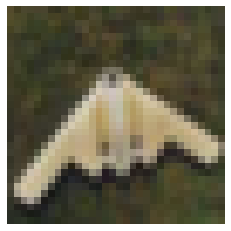

x.shape (1, 32, 32, 3)
[[9.9804926e-01 4.9385879e-10 1.9507998e-03 5.3565498e-12]]
predicted_class 0
correct_class 0
int64


In [91]:
p = 52
x = x_test[p]
x_org = x.copy()
print(x.shape)
plt.imshow(x.reshape(32, 32, 3), cmap="gray")
plt.axis("off")
plt.show()
x = np.expand_dims(x, axis=0)
print("x.shape", x.shape)
# x = preprocess_input(x)
preprocessed_input = x
predictions = model.predict(preprocessed_input)
print(predictions)
predicted_class = np.argmax(predictions)
print("predicted_class", predicted_class)
print("correct_class",  np.argmax(y_test[p]))
print(predicted_class.dtype)

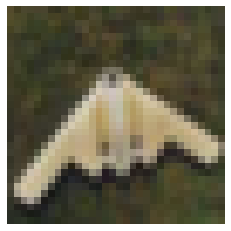

1
2
3
4


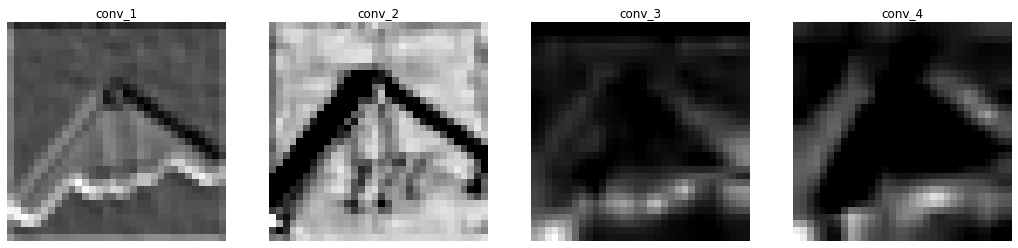

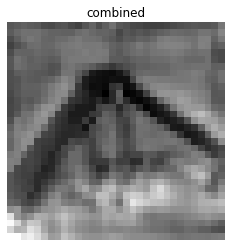

(32, 32, 3)


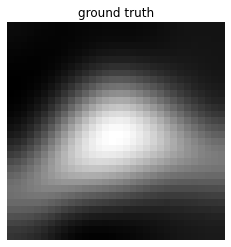

KL divergenvce
0.10580298921774178


In [92]:
plt.imshow(x_org.reshape(32, 32, 3), cmap="gray")
plt.axis("off")
plt.show()
f, a = plt.subplots(1, 4, figsize=(18, 36))
for i in range(1, 5):
    print(i)
    layer_name = "conv_"+str(i)
    cam, heatmap = grad_cam(model, preprocessed_input, predicted_class, layer_name, sparse=False)
    if i ==1:
        combined = np.zeros((heatmap.shape))
    combined += heatmap
    # cam_gray = cam.mean(axis=2)
    a[i-1].imshow(heatmap, cmap="gray")
    a[i-1].title.set_text(layer_name)
    a[i-1].axis('off')
plt.show()

combined /= np.sum(combined)
# combined = np.maximum(combined, 0)
plt.imshow(combined, cmap="gray")
plt.title("combined")
plt.axis("off")
plt.show()

x_comb_gt = scipy.ndimage.gaussian_filter(x_org.reshape(32, 32, 3), 4, order=0, output=None, mode='reflect', cval=0.0, truncate=4.0) 
print(x_comb_gt.shape)
x_comb_gt = np.mean(x_comb_gt, axis=-1)
plt.imshow(x_comb_gt, cmap="gray")
plt.title("ground truth")
plt.axis("off")
plt.show()

print("KL divergenvce")
print(stats.entropy(x_comb_gt.flatten(), combined.flatten()))

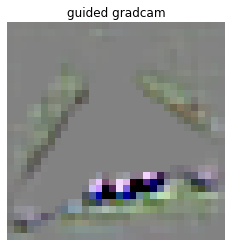

In [93]:
register_gradient()
guided_model = modify_backprop(model, 'GuidedBackProp')
saliency_fn = compile_saliency_function(guided_model, 'conv_4')
saliency = saliency_fn([preprocessed_input, 0])
gradcam = saliency[0] * heatmap[..., np.newaxis]

plt.imshow(deprocess_image(gradcam))
plt.title("guided gradcam")
plt.axis("off")
plt.show()

In [20]:
x_comb_gt /= np.sum(x_comb_gt)
print(np.sum(x_comb_gt))
print(stats.entropy(x_comb_gt.flatten(), combined.flatten()))
print(np.sum(combined))

1.0
0.09065477949041621
0.9999999999999999


In [0]:
preprocessed_x_t = np.ones((len(x_test), 1, 112, 112, 1))
preprocessed_y_t = np.ones((len(x_test)))
preprocessed_y_t = preprocessed_y_t.astype(np.int64)
for i, img in enumerate(x_test):
  # preprocessed_x_t[i] = np.expand_dims(img, axis=0)
  # preprocessed_x_t[i] = img
  preprocessed_y_t[i] = np.argmax(y_test[i])
preprocessed_x_t = x_test
preprocessed_y_t[0].dtype
preprocessed_x_t.shape
sorted_arg = preprocessed_y_t.argsort()
sorted_x = preprocessed_x_t[sorted_arg]
sorted_x.shape
sorted_y = preprocessed_y_t[sorted_arg]
sorted_y

border = []
for i in range(10):
  border.append(np.where(sorted_y==i)[0][0])
border.append(len(sorted_y))
border

numbers = {}
for i in range(0, 10):
  numbers[i] = sorted_x[border[i]:border[i+1]]

overlap 3

Create dataset

In [22]:
len(y_test)
argmaxed_y = np.ones(len(y_test)).astype(np.int16)
for i, y in enumerate(y_test):
  argmaxed_y[i] = np.argmax(y).astype(np.int16)
sorted_arg = argmaxed_y.argsort()
sorted_x = x_test[sorted_arg].copy()
sorted_y = argmaxed_y[sorted_arg].copy()

border = []
c = 0
for i, y in enumerate(sorted_y):
  if y == c:
    border.append(i)
    c += 1
border.append(len(y_test))
border

[0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]

In [15]:
model = Sequential()
# model.add(Conv2D(32, kernel_size=3, padding='same', activation='relu', name='conv_1'))

# model.add(Conv2D(32, kernel_size=3, padding='same', input_shape=(112, 112, 1), activation="relu", name='conv_1')) 
# model.add(Conv2D(32, kernel_size=3, padding='same', input_shape=(64, 64, 3), activation="relu", name='conv_1'))
model.add(Conv2D(32, kernel_size=3, padding='same', input_shape=(64, 64, 3), activation='relu', name='conv_1'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(KW(round(32*ratio[0]), 1.5, 32, name="sparse_1"))
# model.add(Activation("relu", name="relu_1"))

model.add(Conv2D(32, kernel_size=3,  activation='relu', name='conv_2'))
# model.add(Conv2D(32, kernel_size=3, padding='same', activation="relu", name='conv_2'))
# model.add(KW(round(32*ratio[1]), 1.5, 32, name="sparse_2"))
# model.add(Activation("relu", name="relu_2"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=3,  padding='same', activation='relu', name='conv_3'))
# model.add(Conv2D(64, kernel_size=3, activation=None, name='conv_3'))
# model.add(KW(round(64*ratio[2]), 1.5, 64, name="sparse_3"))
# model.add(Activation("relu", name="relu_3"))
# model.add(Conv2D(64, kernel_size=3, activation="relu", name='conv_4'))
model.add(Conv2D(64,  kernel_size=3, activation="relu", name='conv_4'))
# model.add(KW(round(64*ratio[3]) , 1.5, 64, name="sparse_4"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(GlobalAveragePooling2D())
# model.add(Dense(512, name='dense_1'))
model.add(Dense(4, name='dense_2'))
# model.add(Conv2D(10, (6, 6), name='dense_1'))
# model.add(Flatten())

model.add(Activation("softmax", name="softmax"))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [0]:
model.load_weights("/content/drive/My Drive/marc_thesis_store/CNN_cifar10_best_4cls.hdf5")

In [0]:
att_test = np.load("/content/drive/My Drive/marc_thesis_store/test_cifar.npy")
gts = np.load("/content/drive/My Drive/marc_thesis_store/test_cifar_gt.npy")

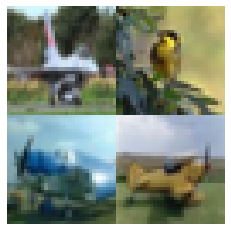

In [18]:
# 0 airplane
# 1 automobile
# 2 bird
# 3 cat

import random 

att_test = np.ones((1000, 32*2, 32*2, 3))

for i in range(1000):
  pos = random.sample(range(0, 4), 4)
  pb = ["{0:b}".format(p) if len("{0:b}".format(p)) == 2 else "0"+"{0:b}".format(p) for p in pos]
  att_test[i][32*int(pb[0][0]):32*int(pb[0][0])+32, 32*int(pb[0][1]):32*int(pb[0][1])+32] = sorted_x[i]
  att_test[i][32*int(pb[1][0]):32*int(pb[1][0])+32, 32*int(pb[1][1]):32*int(pb[1][1])+32] = sorted_x[border[1]+i]
  att_test[i][32*int(pb[2][0]):32*int(pb[2][0])+32, 32*int(pb[2][1]):32*int(pb[2][1])+32] = sorted_x[border[2]+i]
  att_test[i][32*int(pb[3][0]):32*int(pb[3][0])+32, 32*int(pb[3][1]):32*int(pb[3][1])+32] = sorted_x[border[3]+i]
plt.imshow(att_test[1])
plt.axis("off")
plt.show()

(64, 64, 3)


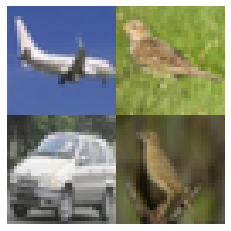

x.shape (1, 64, 64, 3)
(1, 4)
predicted_class 0
correct_class 0
int64


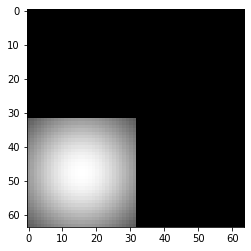

In [37]:
p = 899
x = att_test[p]
x_org = x.copy()
print(x.shape)
plt.imshow(x.reshape(64, 64, 3), cmap="gray")
plt.axis("off")
plt.show()
x = np.expand_dims(x, axis=0)
print("x.shape", x.shape)
# x = preprocess_input(x)
preprocessed_input = x
predictions = model.predict(preprocessed_input)
print(predictions.shape)
predicted_class = np.argmax(predictions)
print("predicted_class", predicted_class)
print("correct_class",  np.argmax(sorted_y[p]))
print(predicted_class.dtype)

plt.imshow(gts[1][p], cmap='gray')
plt.show()

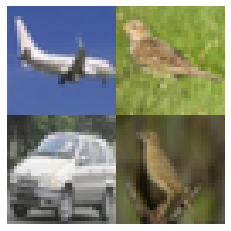

1
2
3
4


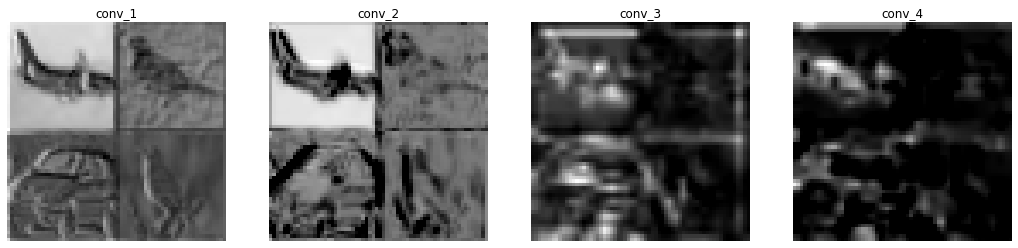

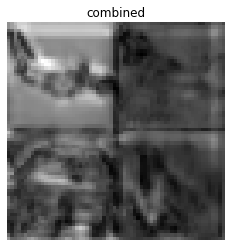

(64, 64, 3)


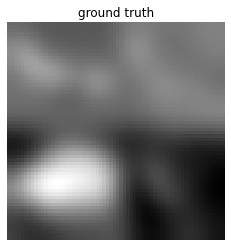

KL divergenvce
0.04908605327829901


In [38]:
# 0 airplane
# 1 automobile
# 2 bird
# 3 cat

plt.imshow(x_org.reshape(64, 64, 3), cmap="gray")
plt.axis("off")
plt.show()
f, a = plt.subplots(1, 4, figsize=(18, 36))

predicted_class = 0

for i in range(1, 5):
    print(i)
    layer_name = "conv_"+str(i)
    cam, heatmap = grad_cam(model, preprocessed_input, predicted_class, layer_name, sparse=False)
    if i ==1:
        combined = np.zeros((heatmap.shape))
    # elif i == 2:
    #   pass
    # else:
    combined += heatmap
    # cam_gray = cam.mean(axis=2)
    a[i-1].imshow(heatmap, cmap="gray")
    a[i-1].title.set_text(layer_name)
    a[i-1].axis('off')
plt.show()

combined /= np.sum(combined[1:])
# combined = np.maximum(combined, 0)
plt.imshow(combined, cmap="gray")
plt.title("combined")
plt.axis("off")
plt.show()

x_comb_gt = scipy.ndimage.gaussian_filter(x_org.reshape(64, 64, 3), 4, order=0, output=None, mode='reflect', cval=0.0, truncate=4.0) 
print(x_comb_gt.shape)
x_comb_gt = np.mean(x_comb_gt, axis=-1)
plt.imshow(x_comb_gt, cmap="gray")
plt.title("ground truth")
plt.axis("off")
plt.show()

print("KL divergenvce")
print(stats.entropy(x_comb_gt.flatten(), combined.flatten()))

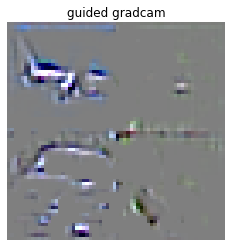

In [39]:
register_gradient()
guided_model = modify_backprop(model, 'GuidedBackProp')
saliency_fn = compile_saliency_function(guided_model, 'conv_4')
saliency = saliency_fn([preprocessed_input, 0])
gradcam = saliency[0] * heatmap[..., np.newaxis]

plt.imshow(deprocess_image(gradcam))
plt.title("guided gradcam")
plt.axis("off")
plt.show()

In [58]:
kl = np.zeros(10000)
show_img = False
batch_size = 50
yb4 = 0
# for img in tqdm(sorted_x):
changeLastLayer = True
results = {}
for i in tqdm(range(4)):
    # print(img.shape)
    # preprocessed_input = np.expand_dims(x_test[i], axis=0)
    # preprocessed_input = np.expand_dims(sorted_x[border[i]:border[i+1]], axis=-1)
    preprocessed_input = np.expand_dims(att_test, axis=-1)
    preprocessed_input = att_test
    # print(preprocessed_input.shape)
    # y = int(np.argmax(y_test[i]))
    y = i
    print("y", y)
    yb4 = y
    combined = batch_grad_cam(model, preprocessed_input, y,  changeLastLayer, sparse=False)
    results[i] = combined
    if show_img:
        plt.imshow(combined[0][0], cmap='gray')
        plt.show()
        plt.imshow(combined[1][0], cmap='gray')
        plt.show()
        plt.imshow(combined[2][0], cmap='gray')
        plt.show()
        plt.imshow(combined[3][0], cmap='gray')
        plt.show()
    img2test = np.sum(combined, axis=0)
    if show_img:
        print("img2test shape", img2test.shape)
        plt.imshow(img2test[0], cmap='gray')
        plt.show()

  0%|          | 0/4 [00:00<?, ?it/s]

y 0
weights shape (1000, 64)
output shape (1000, 31, 31, 64)
 
weights shape (1000, 64)
output shape (1000, 29, 29, 64)
 


 25%|██▌       | 1/4 [00:16<00:50, 16.84s/it]

y 1
weights shape (1000, 64)
output shape (1000, 31, 31, 64)
 
weights shape (1000, 64)
output shape (1000, 29, 29, 64)
 


 50%|█████     | 2/4 [00:30<00:31, 15.96s/it]

y 2
weights shape (1000, 64)
output shape (1000, 31, 31, 64)
 
weights shape (1000, 64)
output shape (1000, 29, 29, 64)
 


 75%|███████▌  | 3/4 [00:44<00:15, 15.19s/it]

y 3
weights shape (1000, 64)
output shape (1000, 31, 31, 64)
 
weights shape (1000, 64)
output shape (1000, 29, 29, 64)
 


100%|██████████| 4/4 [00:57<00:00, 14.49s/it]


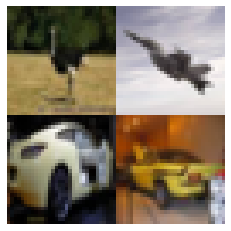

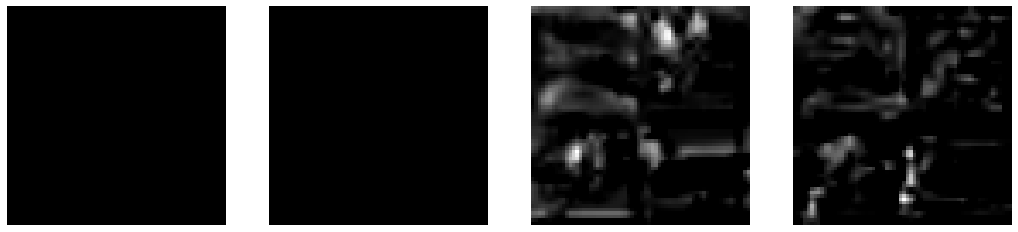

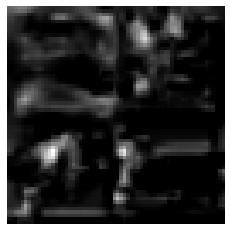

In [59]:
plt.imshow(att_test[-1].reshape(64, 64, 3), cmap='gray')
plt.axis('off')
plt.show()

f, a = plt.subplots(1, 4, figsize=(18, 36))
a[0].imshow(combined[0][0], cmap='gray')
a[0].axis('off')
a[1].imshow(combined[0][1], cmap='gray')
a[1].axis('off')
a[2].imshow(combined[0][2], cmap='gray')
a[2].axis('off')
a[3].imshow(combined[0][3], cmap='gray')
a[3].axis('off')
plt.show()
img2test = np.sum(combined[0], axis=0)
img2test = img2test/np.sum(img2test)
plt.imshow(img2test, cmap='gray')
plt.axis('off')
plt.show()

TypeError: ignored

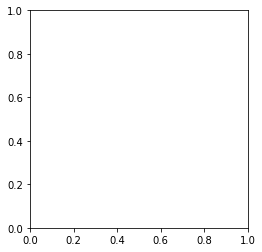

In [154]:
register_gradient()
guided_model = modify_backprop(model, 'GuidedBackProp')
saliency_fn = compile_saliency_function(guided_model, 'conv_4')
saliency = saliency_fn([preprocessed_input, 0])
gradcam = saliency[0] * heatmap[..., np.newaxis]

plt.imshow(deprocess_image(gradcam))
plt.title("guided gradcam")
plt.axis("off")
plt.show()

In [60]:
eps = np.finfo(np.float64).eps

def compKL(salMap, posMap):
  fm = posMap / (np.sum(posMap) + eps)
  sm = salMap / (np.sum(salMap) + eps)
  return np.sum( fm * np.log( (fm + eps) / (sm + eps) ) )

kls = np.zeros((4000))
temp = []
for i in range(0, 4):
  gt = gts[i]
  pmaps = results[i]
  assert len(gt) == len(pmaps)
  for j in range(len(gt)):
    g = gt[j].squeeze()
    pmap = np.sum(pmaps[j][1:], axis=0)
    pmap /= np.sum(pmap)
    kl = compKL(g, pmap)
    if kl == np.inf:
      print("inf")
      continue
    kls[(i*1000)+j] = kl
    temp.append(kl)
  print(i, "mean kl", np.mean(temp))
print(np.mean(kls))

0 mean kl 20.259924931037183
1 mean kl 20.364258992277296
2 mean kl 20.744747910639852
3 mean kl 21.04758330923529
21.04758330923529


In [49]:
kls.mean()

20.480074818797956

In [120]:
import random
comb_x = np.zeros((10000, 112, 112))
comb_y = np.zeros((10000)).astype(np.int16)
gt_x = np.zeros((10000, 112, 112))
for i in range(10000):
  nums = random.sample(range(0, 10), 3)
  tar = nums[0]
  noises = nums[1:]
  tar_arg = random.sample(range(len(numbers[tar])), 1)
  noise1_arg = random.sample(range(len(numbers[noises[0]])), 1)
  noise2_arg = random.sample(range(len(numbers[noises[1]])), 1)
  x_comb = (numbers[tar][tar_arg]+numbers[noises[0]][noise1_arg]+numbers[noises[1]][noise2_arg])
  x_comb [x_comb  > 1] = 1
  comb_x[i] = np.squeeze(x_comb, axis=-1)
  comb_y[i] = np.int(tar)
  x_gt = numbers[tar][tar_arg]
  x_gt =  scipy.ndimage.gaussian_filter(x_gt, 4, order=0, output=None, mode='reflect', cval=0.0, truncate=4.0) 
  x_gt /= np.sum(x_gt)
  gt_x[i] = np.squeeze(x_gt, axis=-1)
plt.imshow(x_comb.reshape(112, 112), cmap='gray')
plt.show()
plt.imshow(x_gt.reshape(112, 112), cmap='gray')
plt.show()
print(comb_y[-1])

ValueError: ignored

In [0]:
del x_train
outfile = "/content/drive/Shared drives/UniLeeds/marc_pj/overlap3.npz"
# outfile = "/content/drive/Shared drives/UniLeeds/marc_pj/overlap4.npz"
# outfile = "/content/drive/Shared drives/UniLeeds/marc_pj/overlap5.npz"
# np.save(outfile, comb_x, comb_y, gt_x)
outfile = "/content/drive/Shared drives/UniLeeds/marc_pj/overlap10.npz"

testfile = np.load(outfile)
sorted_x = testfile["arr_0"]
sorted_y = testfile["arr_1"]
gt_x = testfile["arr_2"]

In [0]:
"""
sorted_arg = comb_y.argsort()
sorted_x = comb_x[sorted_arg]
sorted_y = comb_y[sorted_arg]
gt_x = gt_x[sorted_arg]
"""

border = []
for i in range(10):
  border.append(np.where(sorted_y==i)[0][0])
border.append(len(sorted_y))
border

[0, 1033, 2052, 3069, 4084, 5050, 5982, 7001, 7997, 8982, 10000]

In [0]:
kl = np.zeros(10000)
show_img = False
batch_size = 50
yb4 = 0
# for img in tqdm(sorted_x):
changeLastLayer = True
results = {}
for i in tqdm(range(10)):
    # print(img.shape)
    # preprocessed_input = np.expand_dims(x_test[i], axis=0)
    preprocessed_input = np.expand_dims(sorted_x[border[i]:border[i+1]], axis=-1)
    # print(preprocessed_input.shape)
    # y = int(np.argmax(y_test[i]))
    y = i
    print("y", y)
    yb4 = y
    combined = batch_grad_cam(model, preprocessed_input, y,  changeLastLayer, sparse=True)
    results[i] = combined
    if show_img:
        plt.imshow(combined[0][0], cmap='gray')
        plt.show()
        plt.imshow(combined[1][0], cmap='gray')
        plt.show()
        plt.imshow(combined[2][0], cmap='gray')
        plt.show()
        plt.imshow(combined[3][0], cmap='gray')
        plt.show()
    img2test = np.sum(combined, axis=0)
    if show_img:
        print("img2test shape", img2test.shape)
        plt.imshow(img2test[0], cmap='gray')
        plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]

y 0
weights shape (1033, 32)
output shape (1033, 56, 56, 32)
 
weights shape (1033, 32)
output shape (1033, 28, 28, 32)
 
weights shape (1033, 64)
output shape (1033, 26, 26, 64)
 
weights shape (1033, 64)
output shape (1033, 24, 24, 64)
 


 10%|█         | 1/10 [00:14<02:09, 14.39s/it]

y 1
weights shape (1019, 32)
output shape (1019, 56, 56, 32)
 
weights shape (1019, 32)
output shape (1019, 28, 28, 32)
 
weights shape (1019, 64)
output shape (1019, 26, 26, 64)
 
weights shape (1019, 64)
output shape (1019, 24, 24, 64)
 


 20%|██        | 2/10 [00:21<01:37, 12.16s/it]

y 2
weights shape (1017, 32)
output shape (1017, 56, 56, 32)
 
weights shape (1017, 32)
output shape (1017, 28, 28, 32)
 
weights shape (1017, 64)
output shape (1017, 26, 26, 64)
 
weights shape (1017, 64)
output shape (1017, 24, 24, 64)
 


 30%|███       | 3/10 [00:28<01:14, 10.61s/it]

y 3
weights shape (1015, 32)
output shape (1015, 56, 56, 32)
 
weights shape (1015, 32)
output shape (1015, 28, 28, 32)
 
weights shape (1015, 64)
output shape (1015, 26, 26, 64)
 
weights shape (1015, 64)
output shape (1015, 24, 24, 64)
 


 40%|████      | 4/10 [00:35<00:57,  9.54s/it]

y 4
weights shape (966, 32)
output shape (966, 56, 56, 32)
 
weights shape (966, 32)
output shape (966, 28, 28, 32)
 
weights shape (966, 64)
output shape (966, 26, 26, 64)
 
weights shape (966, 64)
output shape (966, 24, 24, 64)
 


 50%|█████     | 5/10 [00:42<00:43,  8.75s/it]

y 5
weights shape (932, 32)
output shape (932, 56, 56, 32)
 
weights shape (932, 32)
output shape (932, 28, 28, 32)
 
weights shape (932, 64)
output shape (932, 26, 26, 64)
 
weights shape (932, 64)
output shape (932, 24, 24, 64)
 


 60%|██████    | 6/10 [00:49<00:32,  8.18s/it]

y 6
weights shape (1019, 32)
output shape (1019, 56, 56, 32)
 
weights shape (1019, 32)
output shape (1019, 28, 28, 32)
 
weights shape (1019, 64)
output shape (1019, 26, 26, 64)
 
weights shape (1019, 64)
output shape (1019, 24, 24, 64)
 


 70%|███████   | 7/10 [00:54<00:22,  7.41s/it]

y 7
weights shape (996, 32)
output shape (996, 56, 56, 32)
 
weights shape (996, 32)
output shape (996, 28, 28, 32)
 
weights shape (996, 64)
output shape (996, 26, 26, 64)
 
weights shape (996, 64)
output shape (996, 24, 24, 64)
 


 80%|████████  | 8/10 [01:02<00:14,  7.40s/it]

y 8
weights shape (985, 32)
output shape (985, 56, 56, 32)
 
weights shape (985, 32)
output shape (985, 28, 28, 32)
 
weights shape (985, 64)
output shape (985, 26, 26, 64)
 
weights shape (985, 64)
output shape (985, 24, 24, 64)
 


 90%|█████████ | 9/10 [01:09<00:07,  7.31s/it]

y 9
weights shape (1018, 32)
output shape (1018, 56, 56, 32)
 
weights shape (1018, 32)
output shape (1018, 28, 28, 32)
 
weights shape (1018, 64)
output shape (1018, 26, 26, 64)
 
weights shape (1018, 64)
output shape (1018, 24, 24, 64)
 


100%|██████████| 10/10 [01:16<00:00,  7.37s/it]


Check the produced priority map

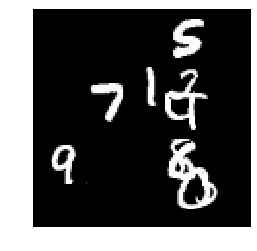

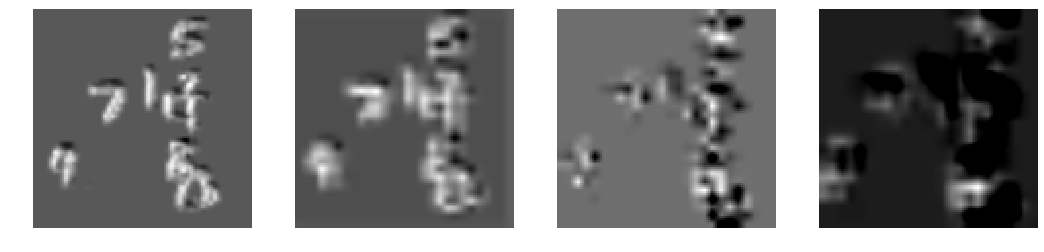

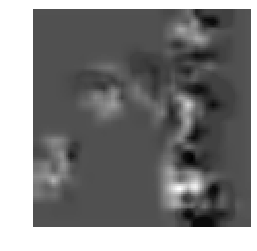

In [0]:
plt.imshow(sorted_x[border[9]].reshape(112, 112), cmap='gray')
plt.axis('off')
plt.show()

f, a = plt.subplots(1, 4, figsize=(18, 36))
a[0].imshow(combined[0][0], cmap='gray')
a[0].axis('off')
a[1].imshow(combined[0][1], cmap='gray')
a[1].axis('off')
a[2].imshow(combined[0][2], cmap='gray')
a[2].axis('off')
a[3].imshow(combined[0][3], cmap='gray')
a[3].axis('off')
plt.show()
img2test = np.sum(combined[0], axis=0)
img2test = img2test/np.sum(img2test)
plt.imshow(img2test, cmap='gray')
plt.axis('off')
plt.show()

Evaluation

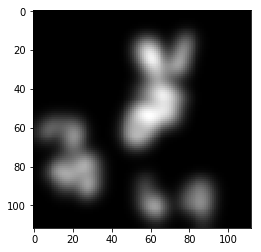

In [0]:
sorted_x_gt = np.ones((sorted_x.shape))
for i, img in enumerate(sorted_x):
  x_comb_gt = scipy.ndimage.gaussian_filter(img.reshape(112, 112), 4, order=0, output=None, mode='reflect', cval=0.0, truncate=4.0) 
  x_comb_gt /= np.sum(x_comb_gt)
  sorted_x_gt[i] = x_comb_gt
plt.imshow(sorted_x_gt[0].reshape(112, 112), cmap='gray')
plt.show()

In [0]:
plt.imshow(gt_x[0], cmap='gray')
plt.show()
np.sum(gt_x[0])

In [0]:
results[0][0].shape
pmap = np.sum(pmaps[0][1:])
pmap /= np.sum(pmap)
np.sum(pmap)
print(np.where(kls == np.inf))
print(results[2][279][1:].shape)
test = results[2][279][1:]
test = np.sum(test, axis=0)
test /= np.sum(test)
print(test.shape)
plt.imshow(test, cmap='gray')
plt.show()
test.max()

In [0]:
kls = np.zeros((10000))
temp = []
for i in range(0, 10):
  gts = gt_x[border[i]:border[i+1]] 
  pmaps = results[i]
  assert len(gts) == len(pmaps)
  for j in range(len(gts)):
    gt = gts[j].squeeze()
    pmap = np.sum(pmaps[j][1:], axis=0)
    pmap /= np.sum(pmap)
    kl = stats.entropy(gt.flatten(), pmap.flatten())
    if kl == np.inf:
      continue
    kls[border[i]+j] = kl
    temp.append(kl)
  print(i, "mean kl", np.mean(temp))
print(kls.mean())

0 mean kl 2.5680342576202184
1 mean kl 2.909500316896012
2 mean kl 2.818598413399716
3 mean kl 2.8447214663226044
4 mean kl 2.8516289927678704
5 mean kl 2.9034391950962597
6 mean kl 2.8880943160276282
7 mean kl 2.900752060024396
8 mean kl 2.846135787700065
9 mean kl 2.85113712658574
2.8508520128730814


overlap 3: kl divergence


In [0]:
ratio_1
overlap 5: kl_divergence
0 mean kl 2.6163089808814353
1 mean kl 2.8753965817893063
2 mean kl 2.866036166178241
3 mean kl 2.839589049469307
4 mean kl 2.8002224193948586
5 mean kl 2.7976602635052896
6 mean kl 2.776942131565275
7 mean kl 2.7878222827655015
8 mean kl 2.7505092012763033
9 mean kl 2.74410191069035
2.737241655913624

overlap 4:
0 mean kl 2.6100659478117705
1 mean kl 2.8564435487711513
2 mean kl 2.8491184604782265
3 mean kl 2.817959019489922
4 mean kl 2.7815341166016436
5 mean kl 2.777701293830135
6 mean kl 2.757888095920567
7 mean kl 2.7704798382440265
8 mean kl 2.7349647613795596
9 mean kl 2.7299936093780865
2.7283556132124596

overlap 3
0 mean kl 2.6085916882382834
1 mean kl 2.8292348078654737
2 mean kl 2.820811807183378
3 mean kl 2.791181309139243
4 mean kl 2.762313691383919
5 mean kl 2.7547291164301706
6 mean kl 2.7405205780466804
7 mean kl 2.750608592249947
8 mean kl 2.721995328715782
9 mean kl 2.7192830214153765
2.717923379904669

overlap 10
0 mean kl 2.7753871251337663
1 mean kl 3.0302378841369033
2 mean kl 2.9991861274385294
3 mean kl 2.9434782696579727
4 mean kl 2.920269374847127
5 mean kl 2.909823645930598
6 mean kl 2.89084027398056
7 mean kl 2.902485352306911
8 mean kl 2.855393801654071
9 mean kl 2.8440827687959764
2.8432295439653377

In [0]:
ratio2 
overlap 10
0 mean kl 2.78751347970808
1 mean kl 3.0770529865454987
2 mean kl 3.049556663938309
3 mean kl 3.0019593188098597
4 mean kl 3.0338597806365777
5 mean kl 2.964702376967148
6 mean kl 2.948014540856044
7 mean kl 2.973138355750508
8 mean kl 2.938854330519554
9 mean kl 2.955926342189674
2.9423290810156018

In [0]:
ratio3
0 mean kl 2.5617848816902273
1 mean kl 2.9615626864881635
2 mean kl 2.879493789567673
3 mean kl 2.8252716277631866
4 mean kl 2.9035969343326524
5 mean kl 2.872025146531248
6 mean kl 2.8751694721629666
7 mean kl 2.908918915133712
8 mean kl 2.8766034414893342
9 mean kl 2.8966481953131815
2.8187283588592575

In [0]:
ratio4
0 mean kl 2.92640563839942
1 mean kl 3.057036631113963
2 mean kl 3.0523901373753484
3 mean kl 3.055620712414837
4 mean kl 3.047826981225571
5 mean kl 3.028641382657027
6 mean kl 3.035205260144986
7 mean kl 3.02426302800163
8 mean kl 3.0306466077710734
9 mean kl 3.0302878726411806
3.023318210534106

In [0]:
ratio 5
0 mean kl 2.6102924420325104
1 mean kl 3.056996957150096
2 mean kl 2.993175665924335
3 mean kl 2.933419261364506
4 mean kl 2.9700195668672977
5 mean kl 2.9511598986357215
6 mean kl 2.9355646228847476
7 mean kl 2.959898989088979
8 mean kl 2.9204692729041324
9 mean kl 2.9291596814920604
2.9291596814920604

In [0]:
ratio 6 
0 mean kl 2.6871636202241023
1 mean kl 3.0877852419167957
2 mean kl 2.995067160916525
3 mean kl 2.9400063153028806
4 mean kl 2.9454528502453514
5 mean kl 2.923680459711544
6 mean kl 2.9050300056313687
7 mean kl 2.923790665282685
8 mean kl 2.8810601626583248
9 mean kl 2.880443626259657
2.880443626259657

In [0]:
ratio 7
0 mean kl 2.560195787736453
1 mean kl 2.8156223253343104
2 mean kl 2.738813908040841
3 mean kl 2.75447621848629
4 mean kl 2.747612327836614
5 mean kl 2.777388223145542
6 mean kl 2.7809560683082064
7 mean kl 2.80386887747819
8 mean kl 2.759662688746271
9 mean kl 2.7521729954598158
2.5248435060348347

In [0]:
ratio 8
0 mean kl 2.656541431748879
1 mean kl 2.8407070131187933
2 mean kl 2.8102019654082584
3 mean kl 2.7997584110905165
4 mean kl 2.8655736959865603
5 mean kl 2.892894408786466
6 mean kl 2.8886316985559644
7 mean kl 2.9027008629355824
8 mean kl 2.865921417443035
9 mean kl 2.8800192946230725
2.8143548547056665

In [0]:
ratio 9
0 mean kl 2.5680342576202184
1 mean kl 2.909500316896012
2 mean kl 2.818598413399716
3 mean kl 2.8447214663226044
4 mean kl 2.8516289927678704
5 mean kl 2.9034391950962597
6 mean kl 2.8880943160276282
7 mean kl 2.900752060024396
8 mean kl 2.846135787700065
9 mean kl 2.85113712658574
2.8508520128730814